In [1]:
import os
import cv2
import joblib
from tqdm import tqdm
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
from ImgProcessing import *

from pyefd import elliptic_fourier_descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
data_dir = r'D:\Nikko\COLLEGE THINGS\Institut Teknologi Bandung (2019 - 2021)\RISPRO\selectivetestimage\class/'
IP = ImgProcessing()
features = list()
labels = list()

for imgfile in tqdm(os.listdir(data_dir)):
    for angle in range(0, 360, 5):
        if imgfile.split('-')[0] == 'yes':
            labels.append(1)
        else:
            labels.append(0)
        
        img = cv2.imread(data_dir+imgfile)
        img_processed = IP.preprocess_img(img)
        rotated = ndimage.rotate(img_processed, angle)
        edge = IP.canny_edge(rotated)
        cnt = IP.get_contour(edge)
        coeffs = IP.extract_efd(cnt)
        features.append(coeffs)
        
#         plt.imshow(cv2.drawContours(np.zeros(rotated.shape), cnt, -1, 255, 3), cmap='gray')
#         plt.imshow(rotated, cmap='gray')
#         plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:52<00:00,  1.15it/s]


In [4]:
dataset = pd.DataFrame(features, columns=[f'coef{i}' for i in range(1,41)])
dataset['label'] = labels
X = dataset.iloc[:,:-1]
y = dataset.label

# Train-val-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=33)
x_train.shape, y_train.shape

((3024, 40), (3024,))

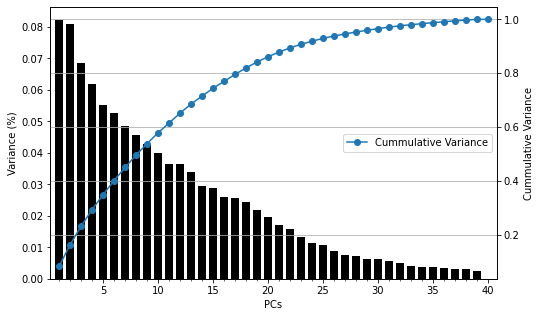

In [6]:
ss = StandardScaler()
X_std = ss.fit_transform(dataset.iloc[:,:-1])

pca = PCA()
X_pca = pca.fit_transform(X_std)

features = range(1, pca.n_components_+1)
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.bar(features, pca.explained_variance_ratio_, color='black', label='Variance (%)')
ax1.set_xlabel('PCs')
ax1.set_ylabel('Variance (%)')
ax1.set_xticks([i+1 for i in range(len(pca.explained_variance_))], minor=True)
ax1.margins(x=0.01)

ax2 = ax1.twinx()
ax2.plot([i+1 for i in range(len(pca.explained_variance_ratio_))], np.cumsum(pca.explained_variance_ratio_), '-o', label='Cummulative Variance')
ax2.set_ylabel('Cummulative Variance')
plt.grid()
plt.legend(loc=7)
plt.show()

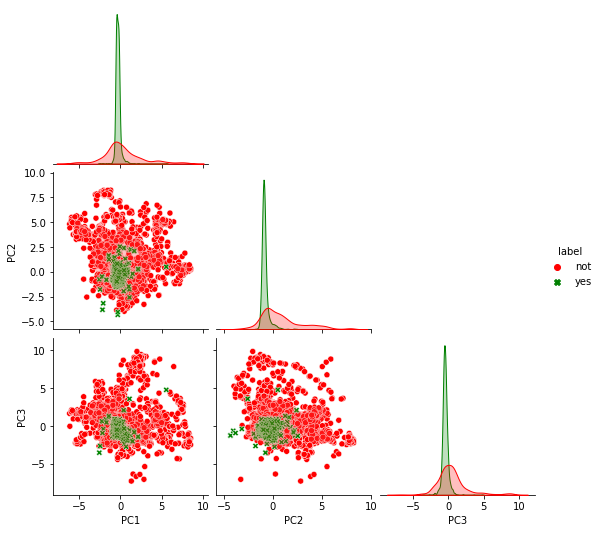

In [7]:
ss = StandardScaler()
X_std = ss.fit_transform(dataset.iloc[:,:-1])

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_std)
df_PCA = pd.DataFrame(X_pca)

df_pairplot = df_PCA
df_pairplot.columns = [f'PC{x+1}' for x in df_pairplot.columns]
df_pairplot['label'] = labels
df_pairplot['label'] = ['not' if x==0 else 'yes' if x==1 else x for x in df_pairplot.label]

pair_plot = sns.pairplot(df_pairplot,
            corner=True,
            diag_kind="kde",
            hue="label",
            markers=["o", "X"],
            palette={'not': 'red', 'yes':'green'})
pair_plot.map_lower(sns.kdeplot, levels=2, color=".1", shade=True, alpha=0.3)
plt.show()

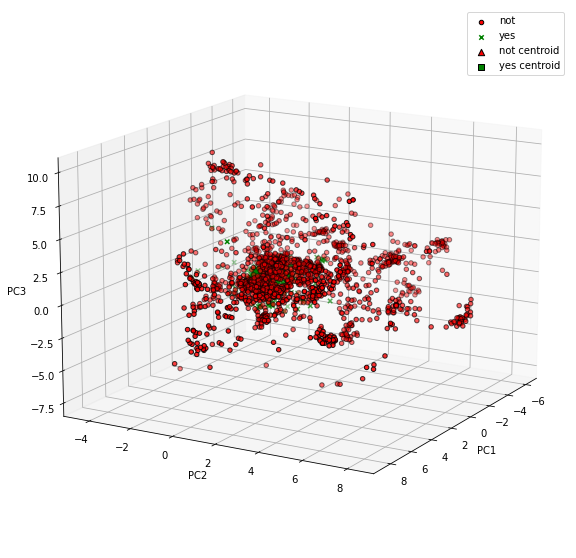

In [8]:
pcx = 'PC1'
pcy = 'PC2'
pcz = 'PC3'
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(df_pairplot[df_pairplot['label']=='not'][pcx], df_pairplot[df_pairplot['label']=='not'][pcy], df_pairplot[df_pairplot['label']=='not'][pcz], color='red', marker='o', edgecolors='k', label='not')
ax.scatter3D(df_pairplot[df_pairplot['label']=='yes'][pcx], df_pairplot[df_pairplot['label']=='yes'][pcy], df_pairplot[df_pairplot['label']=='yes'][pcz], color='green', marker='x', edgecolors='k', label='yes')

# plot centroid
ax.scatter3D(df_pairplot[df_pairplot['label']=='not'][pcx].mean(), df_pairplot[df_pairplot['label']=='not'][pcy].mean(), df_pairplot[df_pairplot['label']=='not'][pcz].mean(), color='red', marker='^', s=40, edgecolors='k', label='not centroid')
ax.scatter3D(df_pairplot[df_pairplot['label']=='yes'][pcx].mean(), df_pairplot[df_pairplot['label']=='yes'][pcy].mean(), df_pairplot[df_pairplot['label']=='yes'][pcz].mean(), color='green', marker='s', s=40, edgecolors='k', label='yes centroid')

ax.set_xlabel(pcx)
ax.set_ylabel(pcy)
ax.set_zlabel(pcz)
ax.view_init(elev=15., azim=30) # rotate view angle
plt.legend()
plt.show()

In [9]:
SVCpipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svc', SVC(random_state=13, probability=True))
])

param_grid = {
    'pca__n_components': np.linspace(1, 20, 20, dtype=int),
    'svc__C': np.linspace(0.1, 50, 10),
    'svc__kernel': ['rbf', 'poly', 'sigmoid']
}

scores = [
    'accuracy',
    'f1'
]

SVCgrid = GridSearchCV(SVCpipe,
                        param_grid=param_grid,
                        scoring=scores,
                        cv=10,
                        n_jobs=-1,
                        verbose=10,
                        refit='accuracy')
SVCresults = SVCgrid.fit(x_train, y_train)

print(SVCresults.best_score_)
print(SVCresults.best_params_)

y_pred = SVCresults.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
0.9877647367385745
{'pca__n_components': 20, 'svc__C': 33.36666666666667, 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       648
           1       0.99      0.98      0.99       648

    accuracy                           0.99      1296
   macro avg       0.99      0.99      0.99      1296
weighted avg       0.99      0.99      0.99      1296

[[642   6]
 [ 13 635]]


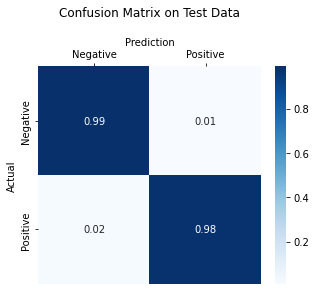

In [10]:
cm = confusion_matrix(y_test, y_pred)
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized confusion matrix

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(norm_cm, fmt = '.2f', annot=True, cmap='Blues')
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_title('Confusion Matrix on Test Data\n')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'])
plt.show()

In [11]:
model_filename = 'eggdet_svc-gs.pkl'

# save best estimator to disk
joblib.dump(SVCgrid.best_estimator_, model_filename)

# load saved model from disk
# SVCgrid = joblib.load(model_filename)

['eggdet_svc-gs.pkl']

In [12]:
KNNpipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'pca__n_components': np.linspace(1, 20, 20, dtype=int), 
    'knn__n_neighbors': np.linspace(1, 20, 20, dtype=int)
}

scores = [
    'accuracy',
    'f1'
]

KNNgrid = GridSearchCV(KNNpipe,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=10,
                    n_jobs=-1,
                    verbose=10,
                    refit='accuracy')
KNNresults = KNNgrid.fit(x_train, y_train)

print(KNNresults.best_score_)
print(KNNresults.best_params_)

y_pred = KNNresults.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Fitting 10 folds for each of 400 candidates, totalling 4000 fits
0.9867702664306165
{'knn__n_neighbors': 1, 'pca__n_components': 18}
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       648
           1       0.97      0.99      0.98       648

    accuracy                           0.98      1296
   macro avg       0.98      0.98      0.98      1296
weighted avg       0.98      0.98      0.98      1296

[[630  18]
 [  8 640]]


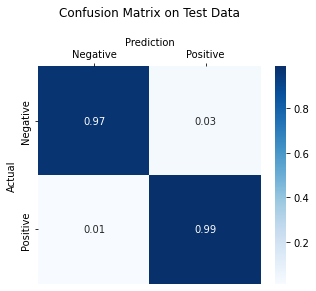

In [13]:
cm = confusion_matrix(y_test, y_pred)
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized confusion matrix

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(norm_cm, fmt = '.2f', annot=True, cmap='Blues')
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_title('Confusion Matrix on Test Data\n')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'])
plt.show()

In [14]:
model_filename = 'eggdet_knn-gs.pkl'

# save best estimator to disk
joblib.dump(KNNgrid.best_estimator_, model_filename)

# load saved model from disk
# KNNgrid = joblib.load(model_filename)

['eggdet_knn-gs.pkl']

In [16]:
RFpipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('rf', RandomForestClassifier())
])

param_grid = {
    'pca__n_components': np.linspace(1, 20, 20, dtype=int),
    "rf__n_estimators": np.linspace(10, 50, 5, dtype=int),
    "rf__max_depth": np.linspace(5, 15, 5, dtype=int),
    'rf__min_samples_split': np.linspace(2, 11, 5, dtype=int),
}

scores = [
    'accuracy',
    'f1'
]

RFgrid = GridSearchCV(RFpipe,
                    param_grid=param_grid,
                    scoring=scores,
                    cv=10,
                    n_jobs=6,
                    verbose=10,
                    refit='accuracy')
RFresults = RFgrid.fit(x_train, y_train)

print(RFresults.best_score_)
print(RFresults.best_params_)

y_pred = RFresults.predict(x_test)
print(classification_report(y_test, y_pred))

Fitting 10 folds for each of 2500 candidates, totalling 25000 fits
0.9735459969838043
{'pca__n_components': 16, 'rf__max_depth': 12, 'rf__min_samples_split': 2, 'rf__n_estimators': 30}
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       648
           1       0.99      0.94      0.96       648

    accuracy                           0.97      1296
   macro avg       0.97      0.97      0.97      1296
weighted avg       0.97      0.97      0.97      1296



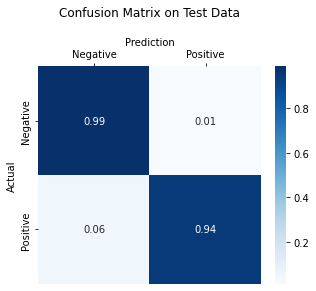

In [17]:
cm = confusion_matrix(y_test, y_pred)
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized confusion matrix

fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(norm_cm, fmt = '.2f', annot=True, cmap='Blues')
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_title('Confusion Matrix on Test Data\n')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'])
plt.show()

In [18]:
model_filename = 'eggdet_rf-gs.pkl'

# save best estimator to disk
joblib.dump(RFgrid.best_estimator_, model_filename)

# load saved model from disk
# RFgrid = joblib.load(model_filename)

['eggdet_rf-gs.pkl']

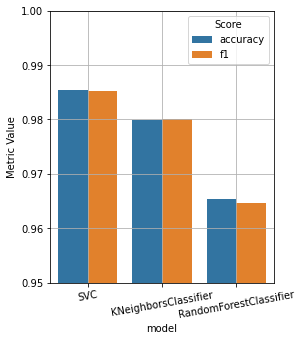

In [19]:
accuracies, f1s, models = list(), list(), list()

for model in [SVCgrid, KNNgrid, RFgrid]:
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracies.append(acc)
    f1s.append(f1)
    models.append(str(model.best_estimator_.steps[2][1]).split('(')[0])

df_plot = pd.DataFrame(zip(accuracies, f1s, models), columns=['accuracy', 'f1', 'model'])
df_melt = pd.melt(df_plot, id_vars='model', var_name='Score', value_name='Metric Value')
fig, ax = plt.subplots(figsize=(4,5))
g = sns.barplot(x='model', y='Metric Value', hue='Score', data=df_melt, ax=ax)
g.set(ylim=(0.95, 1))
plt.xticks(rotation=10)
plt.grid()
plt.show()